In [31]:
import numpy as np
import pandas as pd
import networkx as nx
from heapq import heappop, heappush
from geopy.distance import geodesic
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pickle

In [32]:
with open('lstm_model.pkl', 'rb') as file:
    lstm = pickle.load(file)
print("Loaded Model")

Loaded Model


In [33]:
def generate_random_traffic_data(num_nodes=50, num_edges=200):
    np.random.seed(42)
    nodes = [f'Node{i}' for i in range(num_nodes)]
    data = {
        'source': np.random.choice(nodes, num_edges),
        'target': np.random.choice(nodes, num_edges),
        'traffic_flow': np.random.randint(50, 200, num_edges),
        'speed': np.random.uniform(30, 80, num_edges),
        'incident': np.random.choice([0, 1], num_edges),  # 0: No incident, 1: Incident
        'weather': np.random.uniform(0, 1, num_edges),  # 0: Clear, 1: Severe
        'day_of_week': np.random.choice(range(7), num_edges),  # 0: Monday, 6: Sunday
        'time_of_day': np.random.choice(range(24), num_edges),  # 0: Midnight, 23: 11 PM
        'events': np.random.choice([0, 1], num_edges),  # 0: No event, 1: Event
        'road_condition': np.random.randint(1, 5, num_edges),
        'public_transport': np.random.choice([0, 1], num_edges),  # 0: No PT, 1: PT available
        'latitude_source': np.random.uniform(-90, 90, num_edges),
        'longitude_source': np.random.uniform(-180, 180, num_edges),
        'latitude_target': np.random.uniform(-90, 90, num_edges),
        'longitude_target': np.random.uniform(-180, 180, num_edges)
    }
    return pd.DataFrame(data)

In [24]:
def predict_future_traffic(data, model, scaler, seq_length=30, steps=10):
    features = ['traffic_flow', 'speed', 'incident', 'weather', 'day_of_week', 'time_of_day', 'events', 'road_condition', 'public_transport']
    scaled_values = scaler.transform(data[features].values)
    current_sequence = scaled_values[-seq_length:]
    predictions = []

    for _ in range(steps):
        prediction = model.predict(current_sequence[np.newaxis, :, :])
        predictions.append(prediction[0])
        prediction = np.hstack((prediction, np.zeros((1, len(features) - 1))))
        current_sequence = np.concatenate([current_sequence[1:], prediction], axis=0)

    predictions = scaler.inverse_transform(np.hstack((np.array(predictions), np.zeros((steps, len(features) - 1)))))
    return predictions

In [25]:
def create_graph(data, future_traffic):
    G = nx.DiGraph()
    future_traffic_dict = dict(zip(data['source'] + '-' + data['target'], future_traffic.flatten()))

    def calculate_weight(row):
        key = row['source'] + '-' + row['target']
        traffic_flow = future_traffic_dict.get(key, row['traffic_flow'])
        road_condition = row['road_condition']
        return traffic_flow * 0.7 + road_condition * 0.3

    for _, row in data.iterrows():
        weight = calculate_weight(row)
        G.add_edge(row['source'], row['target'], weight=weight, latitude_source=row['latitude_source'], longitude_source=row['longitude_source'], latitude_target=row['latitude_target'], longitude_target=row['longitude_target'])

    return G

In [26]:
def heuristic(a, b, G):
    coord_a = (G.nodes[a]['latitude'], G.nodes[a]['longitude'])
    coord_b = (G.nodes[b]['latitude'], G.nodes[b]['longitude'])
    return geodesic(coord_a, coord_b).kilometers

def astar_path(graph, start, goal):
    queue = [(0, start, [])]
    seen = set()
    min_cost = {start: 0}

    while queue:
        (cost, current, path) = heappop(queue)

        if current in seen:
            continue

        path = path + [current]
        seen.add(current)

        if current == goal:
            return path

        for neighbor, attr in graph[current].items():
            weight = attr['weight']
            old_cost = min_cost.get(neighbor, float('inf'))
            new_cost = cost + weight
            if new_cost < old_cost:
                min_cost[neighbor] = new_cost
                heappush(queue, (new_cost + heuristic(neighbor, goal, graph), neighbor, path))

    return []

In [27]:
def preprocess_graph(graph):
    ch = nx.floyd_warshall(graph)
    return ch

def predict_travel_time_and_path(graph, start, end, current_time, vehicle_type):
    path = astar_path(graph, start, end)
    total_weight = sum(graph[u][v]['weight'] for u, v in zip(path[:-1], path[1:]))

    vehicle_speed_factor = {'car': 1.0, 'bus': 0.8, 'bike': 1.2}
    travel_time = total_weight / vehicle_speed_factor.get(vehicle_type, 1.0)

    return travel_time, path

def visualize_graph_and_path(graph, path):
    pos = {node: (graph.nodes[node]['longitude'], graph.nodes[node]['latitude']) for node in graph.nodes()}
    edge_colors = ['blue' if (u, v) in zip(path[:-1], path[1:]) or (v, u) in zip(path[:-1], path[1:]) else 'black' for u, v in graph.edges()]

    plt.figure(figsize=(12, 8))
    nx.draw(graph, pos, with_labels=True, node_size=300, node_color='red', edge_color=edge_colors, width=2, font_size=10)
    plt.title('Graph with Shortest Path Highlighted')
    plt.show()

In [28]:
pip install gradio

1/1 [==============================] - 0s 66ms/step
Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://f5cebcdda4177ce916.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://f5cebcdda4177ce916.gradio.live
Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://d1ff232932eb359d89.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://d1ff232932eb359d89.gradio.live


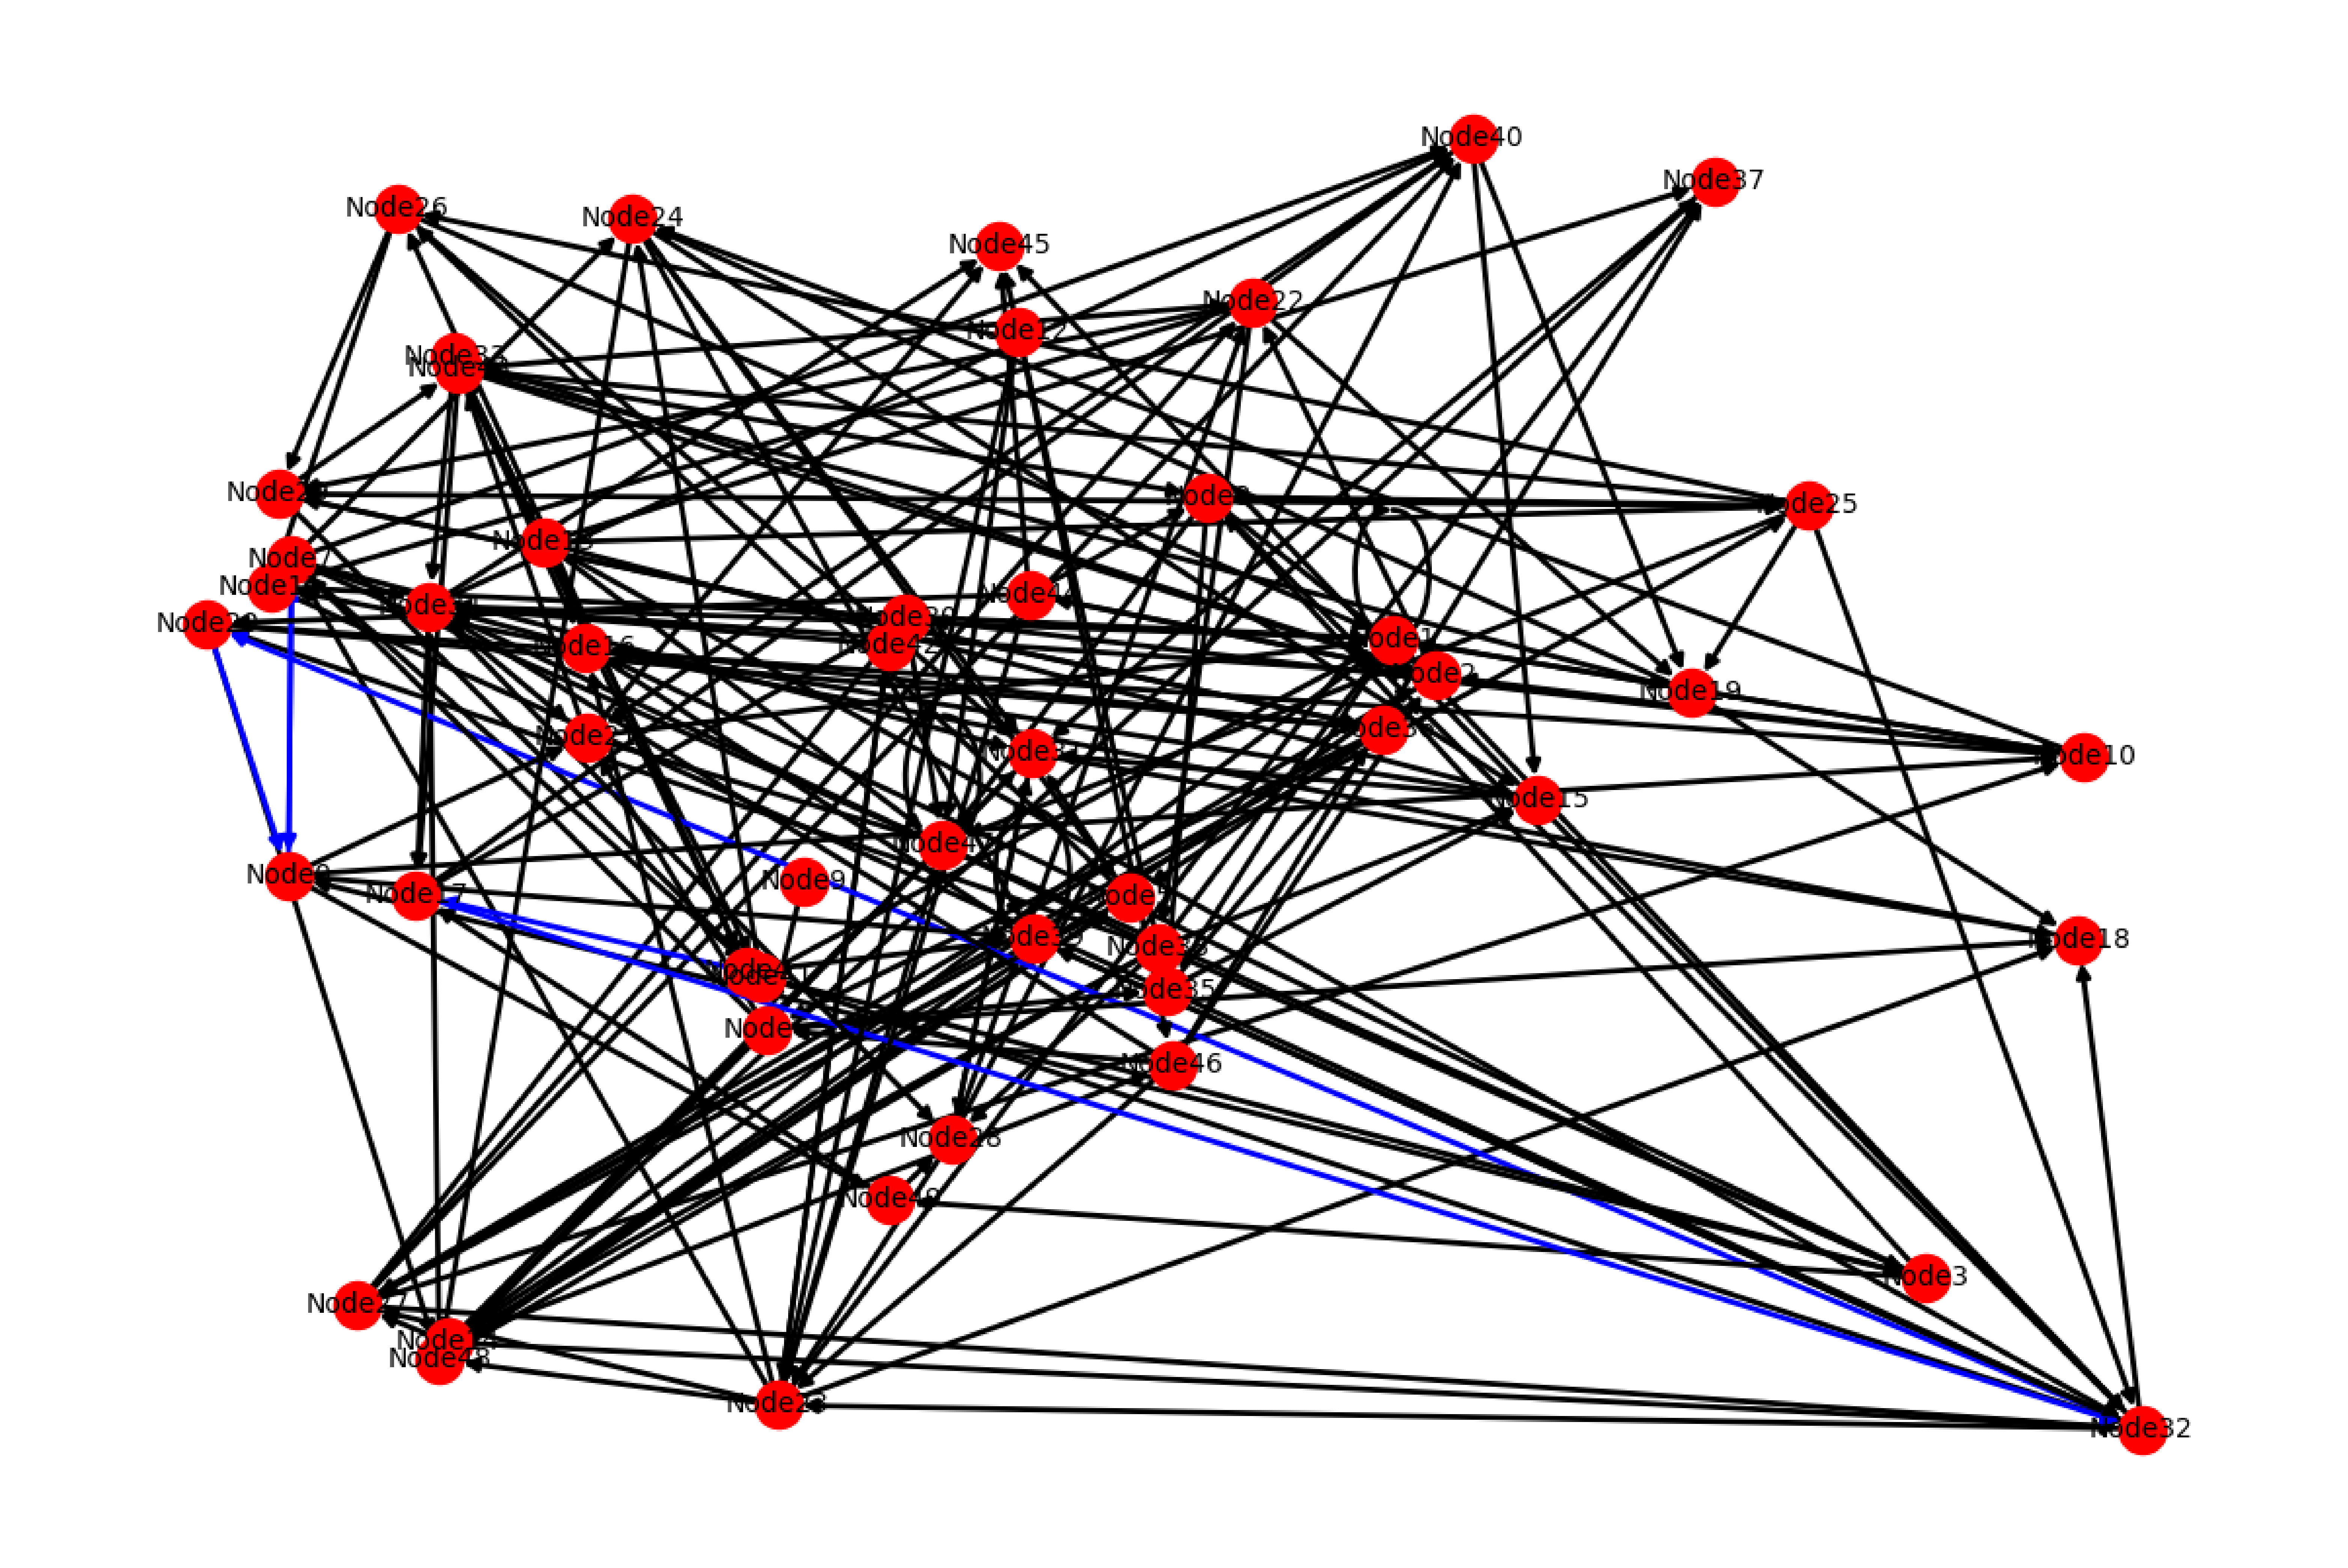

In [34]:
import numpy as np
import gradio as gr
from google.colab import files

traffic_data = generate_random_traffic_data()
with open('lstm_model.pkl','rb') as f:
    lstm_model = pickle.load(f)

with open('lstm_scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
future_traffic = predict_future_traffic(traffic_data, lstm_model, scaler)
G = create_graph(traffic_data, future_traffic)
for node in G.nodes():
        source_nodes = traffic_data[traffic_data['source'] == node]
        if not source_nodes.empty:
            G.nodes[node]['latitude'] = source_nodes['latitude_source'].values[0]
            G.nodes[node]['longitude'] = source_nodes['longitude_source'].values[0]
        else:
            target_nodes = traffic_data[traffic_data['target'] == node]
            if not target_nodes.empty:
                G.nodes[node]['latitude'] = target_nodes['latitude_target'].values[0]
                G.nodes[node]['longitude'] = target_nodes['longitude_target'].values[0]

preprocessed_graph = preprocess_graph(G)

def get_sample_inputs():
        current_time = np.random.randint(0, 24)
        vehicle_type = np.random.choice(['car', 'bus', 'bike'])
        source = np.random.choice(list(G.nodes()))
        destination = np.random.choice(list(G.nodes()))
        return current_time, vehicle_type, source, destination

def predict_travel_time_and_path(graph, start, end, current_time, vehicle_type):
        path = astar_path(graph, start, end)
        total_weight = sum(graph[u][v]['weight'] for u, v in zip(path[:-1], path[1:]))
        vehicle_speed_factor = {'car': 1.0, 'bus': 0.8, 'bike': 1.2}
        travel_time = total_weight / vehicle_speed_factor.get(vehicle_type, 1.0)
        return travel_time, path

def visualize_graph_and_path(graph, path):
    pos = {node: (graph.nodes[node]['longitude'], graph.nodes[node]['latitude']) for node in graph.nodes()}
    edge_colors = ['blue' if (u, v) in zip(path[:-1], path[1:]) or (v, u) in zip(path[:-1], path[1:]) else 'black' for u, v in graph.edges()]

    plt.figure(figsize=(12, 8))
    nx.draw(graph, pos, with_labels=True, node_size=300, node_color='red', edge_color=edge_colors, width=2, font_size=10)
    plt.title('Graph with Shortest Path Highlighted')
    plt.savefig('graph.png')

# Assuming these utility functions are defined somewhere in your code
def text_to_np_str(text):
    return np.str_(text)

def numpy_array_to_str(np_array):
    return str(np_array)

# Define the interfaces
def predict_travel_time_and_path_interface(current_time, vehicle_type, source, destination):
    vehicle_type = text_to_np_str(vehicle_type)
    source = text_to_np_str(source)
    destination = text_to_np_str(destination)

    travel_time, path = predict_travel_time_and_path(G, source, destination, current_time, vehicle_type)

    path_as_list = [str(node) for node in path]

    # Return a tuple with travel time and path
    return str(travel_time), ", ".join(path_as_list)  # Convert path to comma-separated string for Gradio interface

def visualize_graph_and_path_interface(source, destination):
    vehicle_type = "car"  # Assuming a default vehicle type for visualization
    source = text_to_np_str(source)
    destination = text_to_np_str(destination)
    travel_time = 0  # Assuming a default travel time for visualization

    _, path = predict_travel_time_and_path(G, source, destination, travel_time, vehicle_type)
    visualize_graph_and_path(G, path)
    return "graph.png"


predict_interface = gr.Interface(
    fn=predict_travel_time_and_path_interface,
    inputs=['number', 'text', 'text', 'text'],
    outputs=['text', 'text'],
    title='Predict Travel Time and Path',
    description='Enter current time (0-23), vehicle type (car/bus/bike), source, and destination.',
)

visualize_interface = gr.Interface(
    fn=visualize_graph_and_path_interface,
    inputs=['text', 'text'],
    outputs='text',
    title='Visualize Shortest Path',
    description='Enter source and destination to visualize the shortest path on the graph.',
)

predict_interface.launch(debug=True)
visualize_interface.launch(debug=True)
img = plt.imread('graph.png')
plt.figure(figsize=(9.6*10, 5.4*10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
print(type(current_time))
print(type(vehicle_type))
print(type(source))
print(type(destination))
print(type(travel_time))
print(type(path))

<class 'int'>
<class 'numpy.str_'>
<class 'numpy.str_'>
<class 'numpy.str_'>
<class 'numpy.float64'>
<class 'list'>
